# ** Описание **

In [1]:
from __future__ import division

import base64
import csv
import pymorphy2
import gzip
import zlib
import numpy as np
from html.parser import HTMLParser
import re
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import bz2
from gensim.parsing.preprocessing import remove_stopwords, split_alphanum, strip_multiple_whitespaces

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt
import logging
import importlib

In [2]:
TRACE_NUM = 400
importlib.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [3]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [4]:
class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

# @convert2unicode as in Python 3, all strings are sequences of Unicode characters
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [5]:
def html2text_bs(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2title_bs(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    title = soup.find('title')
    if title:
        return title.get_text()
    else:
        return ''
    
def html_has_h1(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    title = soup.find('h1')
    if title:
        return 1
    else:
        return 0
    
def html_has_h2(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    h = soup.find('h2')
    if h:
        return 1
    else:
        return 0
    
def html_has_video(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    h = soup.find('video')
    if h:
        return 1
    else:
        return 0
    
def html_description_len(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    tag = soup.find("meta", {"name":"description"})
    content = ''
    if tag:
        content += str(tag.get('content'))
        content += str(tag.get('value'))
    return len(content)
    
def html_description_words_num(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    tag = soup.find("meta", {"name":"description"})
    content = ''
    if tag:
        content += str(tag.get('content'))
        content += str(tag.get('value'))
    return len(list(pymorphy_tokenizer(content)))
    
def html_image_num(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    tags = soup.find_all("img")
    return len(tags) 
    
def html_image_with_alt_num(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    tags = soup.find_all("img", alt=True)
    return len(tags)

def html_links_num(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    return len(soup.find_all('a'))

def html_unique_links_num(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    out_links = []
    for link in soup.find_all('a'):
        url = link.get('href')
        out_links.append(urlparse(url).netloc)
    return len(list(set(out_links)))
   
def html_self_links_num(raw_html, self_url):
    soup = BeautifulSoup(raw_html, "html.parser")
    count = 0
    for link in soup.find_all('a'):
        url = link.get('href')
#         print('from', urlparse(url).netloc,  'to', urlparse(self_url).netloc)
        if urlparse(url).netloc == urlparse(self_url).netloc:
            count += 1
    return count

def html2anchors_bs(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")    
    soup = soup.find('body')
    anchors = []
    if soup:
        anchors = [a.get_text() for a in soup.find_all('a')]
    return ''.join(anchors)

#### Выбираем какой метод для конвертации html в текст будет основным

In [6]:
html2text = html2text_bs
# html2text = html2text_parser

#### Методы для токенизации текста

In [7]:
@convert2lower
def easy_tokenizer(text):
    word = ''
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = ''
    if word: yield word

PYMORPHY_CACHE = {}
df = pymorphy2.MorphAnalyzer()

@convert2lower
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = df.parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [8]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [9]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a / b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def get_stopwords_ratio(words):
    ru_sw = stopwords.words('russian')
    en_sw = stopwords.words('english')
    sw = en_sw + ru_sw
    sw_count = 0
    for word in words:
        if word in sw:
            sw_count += 1
    return safe_divide(sw_count, len(words))
    
def get_text_without_stopwords(words):
    ru_sw = stopwords.words('russian')
    en_sw = stopwords.words('english')
    sw = en_sw + ru_sw
    without_sw = [word for word in words if word not in sw]
    return ' '.join(list(without_sw))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\miracle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def total_len(words):
    return len(''.join(words))

def get_title_words_num(html):
    title = html2title_bs(html)
    return len(list(easy_tokenizer(title)))

def get_anchors_words_num(html):
    anchors = html2anchors_bs(html)
    anchors_words = easy_tokenizer(anchors)
    return len(list(anchors_words))

class Zlib():
    
    def __init__(self, html):
        self.html = html
        self.compressed = zlib.compress(html)
        
    def get_zlib_compr_num(self):
        return len(self.compressed)

    def get_zlib_compr_lvl(self):
        return safe_divide(len(self.html), len(self.compressed))

class Bz2():
    
    def __init__(self, html):
        self.html = html
        self.compressed = bz2.compress(html)
    
    def get_bz2_compr_num(self):
        return len(self.compressed)

    def get_bz2_compr_lvl(self):
        return safe_divide(len(self.html), len(self.compressed))

class Gzip():
    
    def __init__(self, html):
        self.html = html
        self.compressed = gzip.compress(html)        
    
    def get_gzip_compr_num(self):
        return len(self.compressed)

    def get_gzip_compr_lvl(self):        
        return safe_divide(len(self.html), len(self.compressed))

def is_secure_url(url):
    res = re.match('https', url)
    if res:
        return 1
    else:
        return 0
        
def calc_features(url, html_data):
    features = {}
    zlib = Zlib(html_data)
    bz2 = Bz2(html_data)
    gzip = Gzip(html_data)
    words = list(html2word(html_data))
    features['words_num'] = len(words)
    features['avg_word_len'] = safe_divide(total_len(words), features['words_num'])
    features['title_words_num'] = get_title_words_num(html_data)
    features['anchor_words_num'] = get_anchors_words_num(html_data)
    features['anchor_words_ratio'] = safe_divide(features['anchor_words_num'], features['words_num'])
    features['zlib_compr_len'] = zlib.get_zlib_compr_num()
    features['zlib_compr_lvl'] = zlib.get_zlib_compr_lvl()
    features['bz2_compr_len'] = bz2.get_bz2_compr_num()
    features['bz2_compr_lvl'] = bz2.get_bz2_compr_lvl()
    features['gzip_compr_num'] = gzip.get_gzip_compr_num()
    features['gzip_compr_len'] = gzip.get_gzip_compr_lvl()
    
    features['url_ssl_certificate'] = is_secure_url(url)
    features['url_len'] = len(url)
    features['url_subdomains_len'] = len(list(url.split('.')))
    features['url_digits'] = len(re.findall(r'\d', url))
    
    features['html_len'] = len(html_data)
    features['visible_percent'] = safe_divide(len(html2text_bs_visible(html_data)), features['html_len'])
    features['h1_presense'] = html_has_h1(html_data)
    features['h2_presence'] = html_has_h2(html_data)
    features['video_presence'] = html_has_video(html_data)
    features['title_len'] = len(html2title_bs(html_data))
    features['description_len'] = html_description_len(html_data)
    features['description_words_num'] = html_description_words_num(html_data)
    features['image_num'] = html_image_num(html_data)
    features['image_with_alt_num'] = html_image_with_alt_num(html_data)
    
    features['unique_words_num'] = len(list(set(words)))
    features['unique_words_ratio'] = safe_divide(features['unique_words_num'], len(words))
    features['comma_num'] = len(html2text(html_data).split(','))
    
    features['stopwords_ratio'] = get_stopwords_ratio(words)
    features['links_num'] = html_links_num(html_data)
    features['self_links_num'] = html_self_links_num(html_data, url)
    features['unique_links_num'] = html_unique_links_num(html_data)
    if features['links_num'] != 0:
        features['unique_links_ratio'] = safe_divide(features['unique_links_num'], features['links_num'])
    else:
        features['unique_links_ratio'] = 1   

    text = html2text(html_data)
    text = remove_stopwords(text)
    text = split_alphanum(text)
    text =  strip_multiple_whitespaces(text)
    features['text'] = text
    
#     for k, v in features.items():
#         print(k, v)
    return list(features.values())

In [12]:
test_html_data = u'''
<html>
<head>
something
<title> Заголовок 
Ololo </title>
</head>
<body>
<div class="image">GERE
<a href="http://www.example.com/eg1">Content1<img  
src="http://image.example.com/img1.jpg" />1</a>
</div>
<div class="image">
<a href="http://www.example.com/eg2">Content2<img  
src="http://image.example.com/img2.jpg" />&*&"??>?}}{<>{^:~?`}}"@!&&$@**(::LD:ASLFSAW)#(*_)#@</a>
</div>
<div class="image">GERE
<a href="http://www.example.com/eg1">Content1<img  
src="http://image.example.com/img1.jpg" />1</a>
</div>
<div class="image">
<a href="http://www.example.com/eg2">Content2<img  
src="http://image.example.com/img2.jpg" />&*&"??>?}}{<>{^:~?`}}"@!&&$@**(::LD:ASLFSAW)#(*_)#@</a>
</div>
<div class="image">GERE
<a href="http://www.example.com/eg1">Content1<img  
src="http://image.example.com/img1.jpg" />1</a>
</div>
<div class="image">
<a href="http://www.example.com/eg2">Content2<img  
src="http://image.example.com/img2.jpg" />&*&"??>?}}{<>{^:~?`}}"@!&&$@**(::LD:ASLFSAW)#(*_)#@</a>
</div>
</body>
спам 1 2 3
</html>
'''
test_url = 'http://ololo.sd234f.sfsdfs.sdf'
test_features = calc_features(test_url, test_html_data.encode())
print(len(test_features), test_features)

34 [22, 5.454545454545454, 2, 9, 0.4090909090909091, 283, 3.6678445229681977, 379, 2.7387862796833775, 295, 3.51864406779661, 0, 30, 4, 3, 1038, 0.2418111753371869, 0, 0, 0, 18, 0, 0, 6, 0, 12, 0.5454545454545454, 1, 0.0, 6, 0, 1, 0.16666666666666666, 'Заголовок Ololo GERE Content 11 Content 2&*&"??>?}}{<>{^:~?`}}"@!&&$@**(::LD:ASLFSAW)#(*_)#@ GERE Content 11 Content 2&*&"??>?}}{<>{^:~?`}}"@!&&$@**(::LD:ASLFSAW)#(*_)#@ GERE Content 11 Content 2&*&"??>?}}{<>{^:~?`}}"@!&&$@**(::LD:ASLFSAW)#(*_)#@ спам 1 2 3']


In [13]:
from multiprocessing import Process, Queue

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

WORKER_NUM = 1

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        for i, line in enumerate(input_file):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
#             print(line.decode("utf-8"))
            parts = line.decode("utf-8").strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)            
            res_queue.put(DocItem(url_id, mark, url, features))
            
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in range(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [ ]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'
# TRAIN_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

train_docs = list(load_csv_multiprocess(TRAIN_DATA_FILE, calc_features))

In [180]:
len(train_docs)

7044

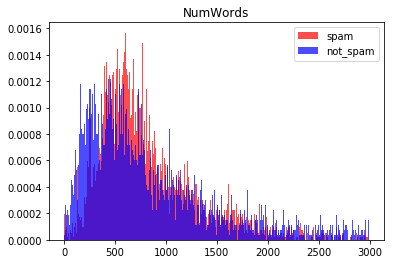

In [23]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

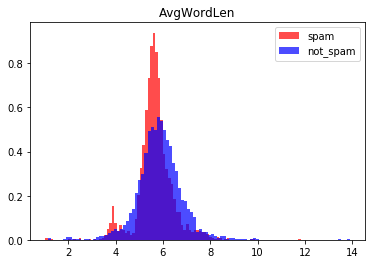

In [24]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

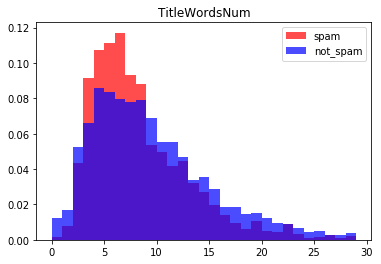

In [27]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('TitleWordsNum')
plt.legend()
plt.show()

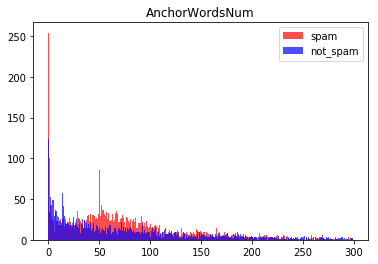

In [39]:
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = range(0, 300, 1)
plt.hist(is_spam_data, bins=bins, color='red', alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', alpha=0.7, label='not_spam')
plt.title('AnchorWordsNum')
plt.legend()
plt.show()

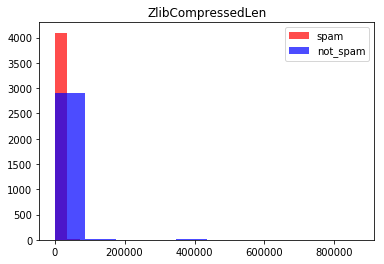

In [81]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, color='red', alpha=0.7, label='spam')
plt.hist(not_spam_data, color='blue', alpha=0.7, label='not_spam')
plt.title('ZlibCompressedLen')
plt.legend()
plt.show()

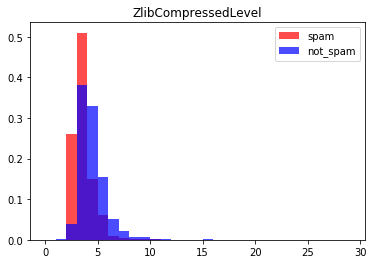

In [41]:
is_spam_data = [doc.features[5] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[5] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('ZlibCompressedLevel')
plt.legend()
plt.show()

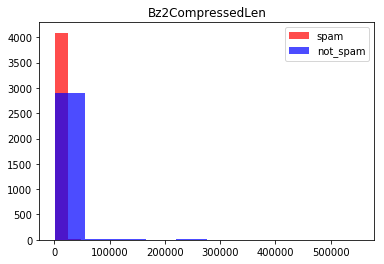

In [82]:
is_spam_data = [doc.features[6] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[6] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, color='red', alpha=0.7, label='spam')
plt.hist(not_spam_data, color='blue', alpha=0.7, label='not_spam')
plt.title('Bz2CompressedLen')
plt.legend()
plt.show()

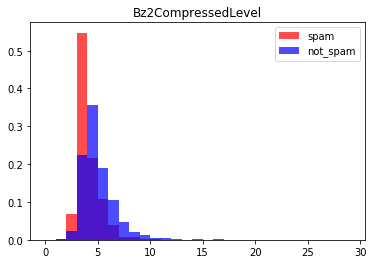

In [45]:
is_spam_data = [doc.features[7] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[7] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('Bz2CompressedLevel')
plt.legend()
plt.show()

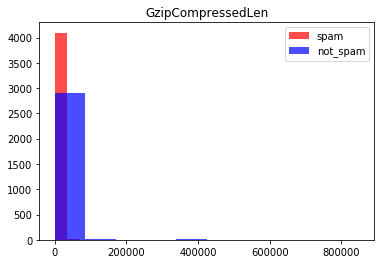

In [83]:
is_spam_data = [doc.features[8] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[8] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, color='red', alpha=0.7, label='spam')
plt.hist(not_spam_data, color='blue', alpha=0.7, label='not_spam')
plt.title('GzipCompressedLen')
plt.legend()
plt.show()

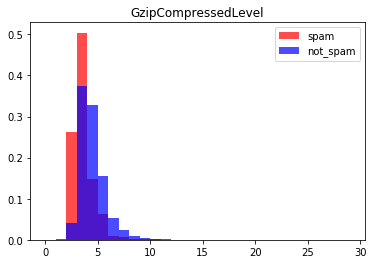

In [49]:
is_spam_data = [doc.features[9] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[9] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('GzipCompressedLevel')
plt.legend()
plt.show()

## ** Классификатор: **

Нужно реализовать

In [97]:
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, make_scorer

class Classifier:
    
    def __init__(self):
        self.params = {
            "colsample_bytree": uniform(0.7, 0.3),
            "gamma": uniform(0, 0.5),
            "learning_rate": uniform(0.03, 0.3), # default 0.1 
            "max_depth": randint(2, 10), # default 3
            "n_estimators": randint(100, 2000)
        }

        self.clf = xgb.XGBRegressor(objective="binary:hinge",
                                    random_state=42,
#                                     n_estimators=2000,
                                    subsample=0.5)
        self.scoring = make_scorer(f1_score, average='weighted')
        
        self.tfidf_maxfeatures = 200
        self.vectorizer = TfidfVectorizer(sublinear_tf=True,
#                                           max_df=0.8,
                                          use_idf=True,
                                          smooth_idf=True,
                                          max_features=self.tfidf_maxfeatures)
        self.simple_features_len = 0
        return


    def predict(self, doc):
        features = np.zeros(self.simple_features_len + self.tfidf_maxfeatures)
        features[:self.simple_features_len] = doc.features[:-1]
        for i in range(self.tfidf_maxfeatures):
            w = re.findall(self.tfidf_fnames[i], doc.features[-1])
            features[self.simple_features_len+i] = len(w)

        ypred = self.best_clf.predict([features])[0]
        return int(ypred)      
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def fit_vectorizer(self, docs):
        corpus = []
        for doc in docs:
            corpus.append(doc.features[-1])
        
        self.tfidf_train = self.vectorizer.fit_transform(corpus)
        self.tfidf_fnames = self.vectorizer.get_feature_names()
        print(self.tfidf_fnames)
    
    def train(self, docs):
        self.fit_vectorizer(docs)
        
        self.simple_features_len = len(docs[0].features) - 1
        
        X = np.zeros((len(docs), self.simple_features_len + self.tfidf_maxfeatures))
        y = np.zeros(len(docs)).astype('int')
         
        for doc_num, doc in enumerate(docs):                            
            #TODO вставить код обучения
            X[doc_num, :self.simple_features_len] = doc.features[:-1]
            for i in range(self.tfidf_maxfeatures):
                w = re.findall(self.tfidf_fnames[i], doc.features[-1])
                X[doc_num, self.simple_features_len+i] = len(w)
            y[doc_num] = doc.is_spam
            trace(doc_num)
            
        folds = 5
        param_comb = 5

        skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
  
        search = RandomizedSearchCV(
            self.clf,
            param_distributions=self.params,
            n_iter=param_comb,
            scoring=self.scoring,
            n_jobs=-1,
            cv=skf.split(X,y),
            verbose=3
        )
        search.fit(X, y)
        print(search.best_params_)
        print(search.best_score_)
        self.best_clf = search.best_estimator_
        return

In [98]:
%%time

classifier = Classifier()
classifier.train(train_docs)

01:41:57 INFO:Complete items 00000


['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '2007', '2008', '2009', '2010', '2011', '21', '22', '23', '24', '25', '30', 'com', 'http', 'ru', 'www', 'без', 'бесплатно', 'более', 'больше', 'будет', 'бы', 'был', 'была', 'были', 'было', 'быть', 'вам', 'вас', 'видео', 'во', 'вот', 'время', 'все', 'всего', 'всех', 'вы', 'где', 'гей', 'года', 'голые', 'гороскоп', 'да', 'даже', 'день', 'диета', 'для', 'до', 'драйвер', 'драйвера', 'его', 'ее', 'ему', 'если', 'есть', 'еще', 'же', 'жизни', 'за', 'здесь', 'знакомства', 'игра', 'игры', 'из', 'или', 'им', 'интернет', 'интим', 'их', 'как', 'карта', 'когда', 'которые', 'который', 'кто', 'лет', 'ли', 'между', 'меня', 'мне', 'может', 'можно', 'москва', 'москвы', 'мы', 'на', 'надо', 'найти', 'нам', 'нас', 'не', 'него', 'несколько', 'нет', 'ни', 'них', 'ничего', 'но', 'новости', 'новых', 'об', 'один', 'однако', 'он', 'она', 'они', 'онлайн', 'от', 'очень', 'по', 'под', 'поис

01:41:58 INFO:Complete items 00500
01:42:01 INFO:Complete items 01000
01:42:02 INFO:Complete items 01500
01:42:04 INFO:Complete items 02000
01:42:05 INFO:Complete items 02500
01:42:06 INFO:Complete items 03000
01:42:08 INFO:Complete items 03500
01:42:10 INFO:Complete items 04000
01:42:12 INFO:Complete items 04500
01:42:13 INFO:Complete items 05000
01:42:15 INFO:Complete items 05500
01:42:16 INFO:Complete items 06000
01:42:17 INFO:Complete items 06500
01:42:19 INFO:Complete items 07000


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 16.3min finished


{'colsample_bytree': 0.8494364775228163, 'gamma': 0.13572537677638374, 'learning_rate': 0.08717797158098115, 'max_depth': 4, 'n_estimators': 218}
0.9659089768039238
CPU times: user 1min, sys: 1.11 s, total: 1min 1s
Wall time: 17min 19s


In [333]:
#Посмотреть, что предсказывается для тестового html
classifier.predict(DocItem(0, 0, test_url , test_features))

1

In [77]:
%%time

TEST_DATA_FILE  = 'kaggle/kaggle_test_data_tab.csv.gz'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

test_docs = list(load_csv_multiprocess(TEST_DATA_FILE, calc_features))

05:32:00 INFO:Complete items 00000 in worker_id 0
05:32:00 INFO:Complete items 00000 in worker_id 1
05:32:00 INFO:Complete items 00000 in worker_id 2
05:32:00 INFO:Complete items 00000 in worker_id 3
05:32:00 INFO:Complete items 00000 in worker_id 4
05:32:00 INFO:Complete items 00000 in worker_id 5
05:32:00 INFO:Complete items 00000 in worker_id 6
05:32:00 INFO:Complete items 00000 in worker_id 7
05:49:56 INFO:Complete items 00500 in worker_id 2
05:50:16 INFO:Complete items 00500 in worker_id 6
05:51:10 INFO:Complete items 00500 in worker_id 5
05:53:43 INFO:Complete items 00500 in worker_id 1
05:58:11 INFO:Complete items 00500 in worker_id 4
06:00:44 INFO:Complete items 00500 in worker_id 3
06:09:25 INFO:Complete items 01000 in worker_id 6
06:09:48 INFO:Complete items 01000 in worker_id 2
06:14:24 INFO:Complete items 01000 in worker_id 1
06:17:25 INFO:Complete items 00500 in worker_id 7
06:19:55 INFO:Complete items 01000 in worker_id 4
06:24:40 INFO:Complete items 00500 in worker_id 0


14:35:25 INFO:Complete items 11000 in worker_id 2
14:36:53 INFO:Complete items 11500 in worker_id 6
14:48:16 INFO:Complete items 09000 in worker_id 5
14:52:52 INFO:Complete items 10500 in worker_id 4
14:57:27 INFO:Complete items 11500 in worker_id 1
14:58:34 INFO:Complete items 12000 in worker_id 6
15:03:33 INFO:Complete items 11500 in worker_id 2
15:10:35 INFO:Complete items 11000 in worker_id 4
15:20:26 INFO:Complete items 09500 in worker_id 7
15:29:07 INFO:Complete items 11500 in worker_id 4
15:33:13 INFO:Complete items 12000 in worker_id 1
15:36:36 INFO:Complete items 12000 in worker_id 2
15:38:02 INFO:Complete items 12500 in worker_id 6
15:40:40 INFO:Complete items 09000 in worker_id 0
15:41:50 INFO:Complete items 10000 in worker_id 7
15:45:00 INFO:Complete items 09500 in worker_id 5
15:52:58 INFO:Complete items 12500 in worker_id 1
15:55:59 INFO:Complete items 12500 in worker_id 2
15:58:37 INFO:Complete items 13000 in worker_id 6
16:00:29 INFO:Complete items 12000 in worker_id 4


CPU times: user 4.05 s, sys: 2.13 s, total: 6.18 s
Wall time: 14h 48min 57s


In [99]:
%%time
print(len(test_docs))
with open('my_submission.csv' , 'wt') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        writer.writerow([item[0], item[3]])

01:59:20 INFO:Complete items 00000


16039


01:59:22 INFO:Complete items 00500
01:59:24 INFO:Complete items 01000
01:59:26 INFO:Complete items 01500
01:59:30 INFO:Complete items 02000
01:59:32 INFO:Complete items 02500
01:59:35 INFO:Complete items 03000
01:59:37 INFO:Complete items 03500
01:59:39 INFO:Complete items 04000
01:59:41 INFO:Complete items 04500
01:59:44 INFO:Complete items 05000
01:59:46 INFO:Complete items 05500
01:59:48 INFO:Complete items 06000
01:59:51 INFO:Complete items 06500
01:59:53 INFO:Complete items 07000
01:59:55 INFO:Complete items 07500
01:59:57 INFO:Complete items 08000
01:59:59 INFO:Complete items 08500
02:00:01 INFO:Complete items 09000
02:00:04 INFO:Complete items 09500
02:00:06 INFO:Complete items 10000
02:00:08 INFO:Complete items 10500
02:00:11 INFO:Complete items 11000
02:00:13 INFO:Complete items 11500
02:00:15 INFO:Complete items 12000
02:00:18 INFO:Complete items 12500
02:00:19 INFO:Complete items 13000
02:00:22 INFO:Complete items 13500
02:00:24 INFO:Complete items 14000
02:00:26 INFO:Comple

CPU times: user 1min 8s, sys: 879 ms, total: 1min 9s
Wall time: 1min 12s
